# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder

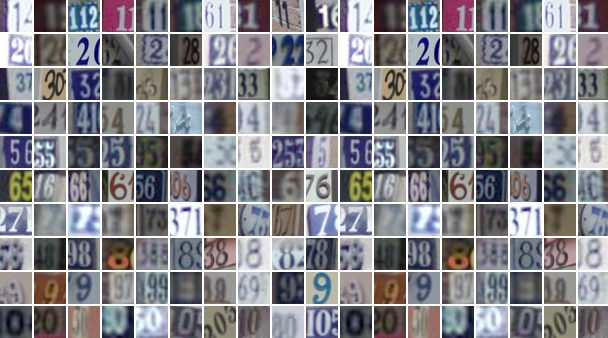
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
# Extracting the training and testing images and labels separatelly from the train and test dictionaries 

X_train = train["X"]
y_train = train["y"]

X_test = test["X"]
y_test_original = test["y"]

X_train.shape, X_test.shape

((32, 32, 3, 73257), (32, 32, 3, 26032))

In [5]:
# Reordering dimensions to (batch number, image dim, colour channels) and normalizing the data

X_train = np.moveaxis(X_train, -1, 0) / 255.
X_test = np.moveaxis(X_test, -1 , 0) / 255.

X_train.shape, X_test.shape

((73257, 32, 32, 3), (26032, 32, 32, 3))

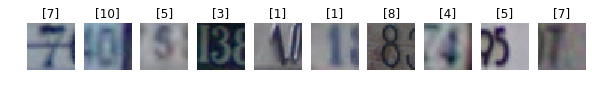

In [5]:
# Plotting 10 random images and their corresponding labels

random = random.sample(range(0,X_train.shape[0]), 10)
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    
    ax[i].set_axis_off()
    ax[i].imshow(X_train[random[i]])
    ax[i].set_title(y_train[random[i]])
   

In [6]:
# Converting the training and test images to grayscale by taking the average across all colour channels for each pixel

X_train_grey = np.mean(X_train, -1, keepdims=True)
X_test_grey = np.mean(X_test, -1, keepdims=True)

X_train_grey.shape, X_test_grey.shape

((73257, 32, 32, 1), (26032, 32, 32, 1))

/Users/migle0703/miniconda3/envs/tensorflow/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


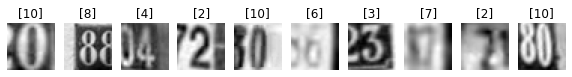

In [7]:
# Plotting 10 random greyscale images and their corresponding labels

random = random.sample(range(0,X_train_grey.shape[0]), 10)
fig, ax = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    
    ax[i].set_axis_off()
    ax[i].imshow(X_train_grey[random[i],:,:,0], cmap='gray')
    ax[i].set_title(y_train[random[i]])

In [8]:
# Getting unique labels 

np.unique(y_train)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [9]:
# One-hot encoding labels 

ohe = OneHotEncoder().fit(y_train)

y_train = ohe.transform(y_train).toarray()
y_test = ohe.transform(y_test_original).toarray()

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [28]:
# Building a model

def get_MLP_model():
    model = Sequential([
        Flatten(input_shape=(X_train[0].shape), name='Flat'), 
        Dense(256, activation='relu', name='Dense_1'),
        Dense(128, activation='relu', name='Dense_2'),
        Dense(64, activation='relu', name='Dense_3'),
        Dense(10, activation='softmax', name='Dense_4')
    ])
    return model

model = get_MLP_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flat (Flatten)               (None, 3072)              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
Dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
Dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
Dense_4 (Dense)              (None, 10)                650       
Total params: 828,490
Trainable params: 828,490
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Callbacks 

checkpoint_path_mlp = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path_mlp,
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_loss',
                            verbose=1)

             
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5) 

In [30]:
# Compiling and training the model

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # when one sample can have multiple classes/labels(probabilities)
    metrics=['accuracy'] 
)

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=30,
                    validation_split=0.10,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/30
1031/1031 [==============================] - 20s 18ms/step - loss: 2.2459 - accuracy: 0.1901 - val_loss: 1.5158 - val_accuracy: 0.4904

Epoch 00001: val_loss improved from inf to 1.51576, saving model to model_checkpoints/checkpoint
Epoch 2/30
1031/1031 [==============================] - 12s 12ms/step - loss: 1.4073 - accuracy: 0.5335 - val_loss: 1.2873 - val_accuracy: 0.5773

Epoch 00002: val_loss improved from 1.51576 to 1.28734, saving model to model_checkpoints/checkpoint
Epoch 3/30
1031/1031 [==============================] - 11s 10ms/step - loss: 1.1764 - accuracy: 0.6260 - val_loss: 1.2133 - val_accuracy: 0.5981

Epoch 00003: val_loss improved from 1.28734 to 1.21326, saving model to model_checkpoints/checkpoint
Epoch 4/30
1031/1031 [==============================] - 10s 10ms/step - loss: 1.0872 - accuracy: 0.6581 - val_loss: 1.0356 - val_accuracy: 0.6766

Epoch 00004: val_loss improved from 1.21326 to 1.03563, saving model to model_checkpoints/checkpoint
Epoch 5/30
1

In [31]:
def learning_curves(history):

    frame = pd.DataFrame(history.history)
    epochs = np.arange(len(frame))

    fig = plt.figure(figsize=(12,4))

    # Loss plot
    ax = fig.add_subplot(121)
    ax.plot(epochs, frame['loss'], label="Training Loss")
    ax.plot(epochs, frame['val_loss'], label="Validation Loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.set_title("Loss vs Epochs")
    ax.legend()

    # Accuracy plot
    ax = fig.add_subplot(122)
    ax.plot(epochs, frame['accuracy'], label="Training Accuracy")
    ax.plot(epochs, frame['val_accuracy'], label="Validation Accuracy")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy vs Epochs")
    ax.legend()
    
    return ax

<AxesSubplot:title={'center':'Accuracy vs Epochs'}, xlabel='Epochs', ylabel='Accuracy'>

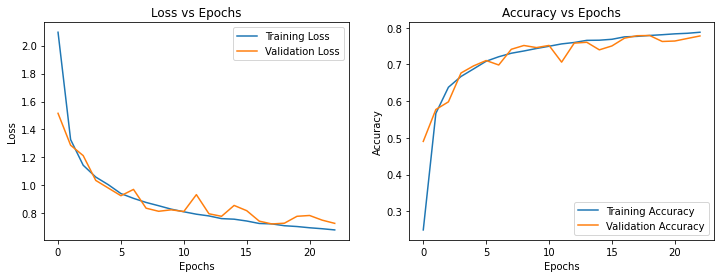

In [32]:
learning_curves(history)

In [33]:
# Getting test loss and accuracy 

def get_test_accuracy(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    return print('loss: {loss:0.3f}, accuracy: {acc:0.3f}'.format(acc=test_acc, loss=test_loss))

In [34]:
get_test_accuracy(model, X_test, y_test)

loss: 0.849, accuracy: 0.744


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [35]:
# Building a CNN model

def get_CNN_model():

    model2 = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(X_train[0].shape), name='conv_1'),
        Conv2D(16, (3, 3), activation='relu', padding="same", name='conv_2'),
        MaxPooling2D(pool_size=(3, 3), name='pool_1'),
        BatchNormalization(),
        Dropout(0.5),
        Flatten(name='flatten'),
        Dense(units=128, activation='relu', name='dense_1'),
        Dense(units=64, activation='relu', name='dense_2'),
        Dense(units=10, activation='softmax', name='dense_3')
        ])
    
    return model2

model2 = get_CNN_model()
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 16)        2320      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 10, 10, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 10, 16)        64        
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)              

In [36]:
# Callbacks 

checkpoint_path_cnn = 'CNN_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path_cnn,
                            save_weights_only=True,
                            save_best_only=True,
                            verbose=1)

             
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5) 

In [37]:
# Compiling and training a model 

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # when one sample can have multiple classes/labels(probabilities)
    metrics=['accuracy'] 
)

history2 = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/30
2061/2061 [==============================] - 126s 61ms/step - loss: 1.4167 - accuracy: 0.5182 - val_loss: 0.5874 - val_accuracy: 0.8153

Epoch 00001: val_loss improved from inf to 0.58737, saving model to CNN_checkpoints/checkpoint
Epoch 2/30
2061/2061 [==============================] - 116s 56ms/step - loss: 0.6447 - accuracy: 0.7959 - val_loss: 0.4943 - val_accuracy: 0.8546

Epoch 00002: val_loss improved from 0.58737 to 0.49427, saving model to CNN_checkpoints/checkpoint
Epoch 3/30
2061/2061 [==============================] - 113s 55ms/step - loss: 0.5528 - accuracy: 0.8263 - val_loss: 0.4070 - val_accuracy: 0.8755

Epoch 00003: val_loss improved from 0.49427 to 0.40696, saving model to CNN_checkpoints/checkpoint
Epoch 4/30
2061/2061 [==============================] - 114s 55ms/step - loss: 0.4945 - accuracy: 0.8437 - val_loss: 0.3771 - val_accuracy: 0.8877

Epoch 00004: val_loss improved from 0.40696 to 0.37706, saving model to CNN_checkpoints/checkpoint
Epoch 5/30
2061/

<AxesSubplot:title={'center':'Accuracy vs Epochs'}, xlabel='Epochs', ylabel='Accuracy'>

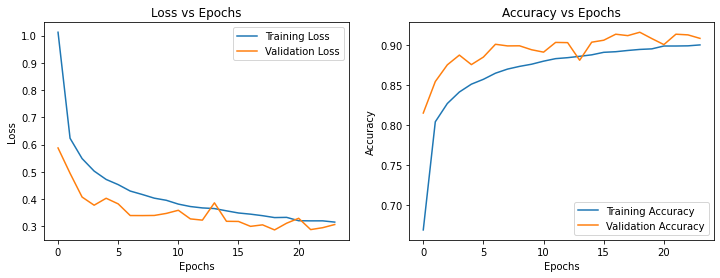

In [38]:
# Getting learning curves

learning_curves(history2)

In [39]:
# Getting test loss and accuracy 

get_test_accuracy(model2, X_test, y_test)

loss: 0.340, accuracy: 0.901


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [40]:
# Creating a new MLP model and loading the weights from the best performance 

model_MPL = get_MLP_model()
model_MPL.load_weights(checkpoint_path_mlp)

In [41]:
# Creating a new CNN model and loading the weights from the best performance 

model_CNN = get_CNN_model()
model_CNN.load_weights(checkpoint_path_cnn)

In [42]:
# Getting model predictions

def model_prediction(model):

    num_test_images = X_test.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = X_test[random_inx, ...]
    random_test_labels = y_test_original[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(1,11), prediction)
        axes[i, 1].set_xticks(np.arange(1,11))
        axes[i, 1].set_title("Categorical distribution. Model prediction")
    
    return plt.show()

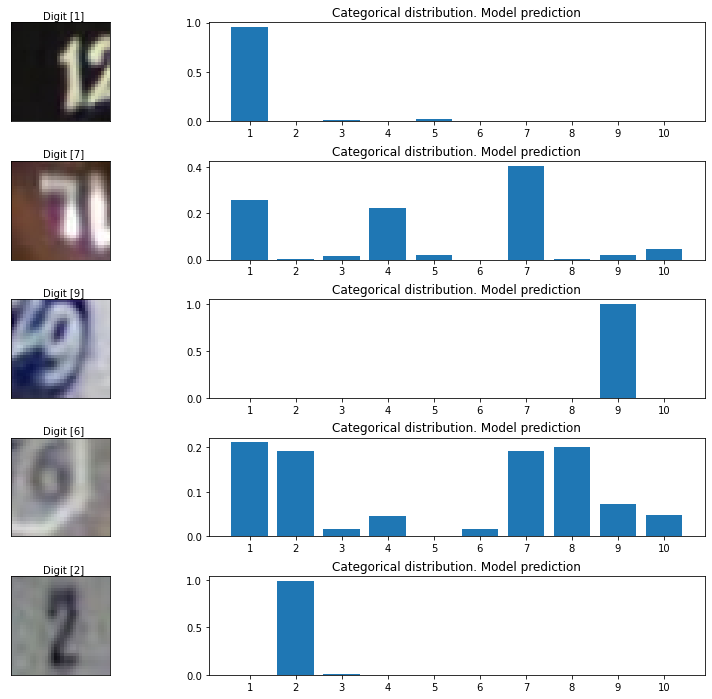

In [43]:
model_prediction(model_MPL)

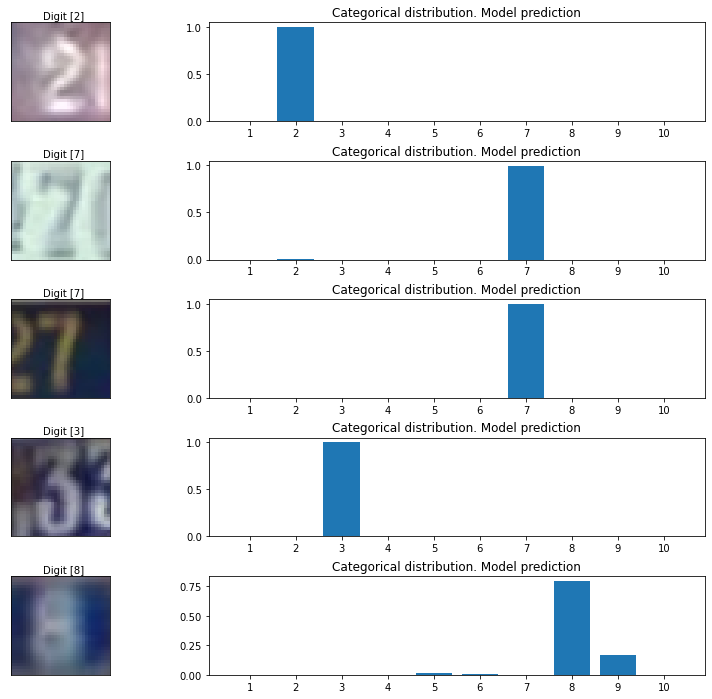

In [32]:
model_prediction(model_CNN)